# All Spectrogram Code Setup

In [22]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
from sklearn.decomposition import nmf # contains the private _beta_divergence functions that we will use
import pandas as pd

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type, ord):
    # TODO: Fix the default norm value to be None, and allow other norms to flow through
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    
    # Normalize the trial based on the specified norm type
    if ord is not None:
        print(f"we are using the {ord}-norm to normalize trials")
        all_patient_trials = [trials / np.linalg.norm(trials, ord=ord, axis=1, keepdims=True) for trials in all_patient_trials]

    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop, sample_rows):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs, window, nperseg, noverlap, log_Sxx):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def erp_gen_welch(x, fs, window, nperseg, noverlap):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def specgram_trials(arr_all_trials, fs, window, nperseg, 
                    trials_samp_idx, filter_row_idx, log_Sxx):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0]) #TODO: Review this - may need to loop channel by channel if the number of channels changes!
        trial_specgrams = [erp_gen_spectrogram(x=arr_all_trials[idx], fs=fs, window=window, nperseg=nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs, window, nperseg, 
                     trials_samp_idx, filter_row_idx, log_Sxx):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), np.around(x_ticks_l), rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper(base_data_dir, core_cat, trials_type,
                                patient_num, session_idx, tot_num_channels, samp_trial_pop, 
                                noverlap,
                                trial_ord,
                                specgram_ord,
                                time_samp_prop,
                                filter_row_idx,                                
                                log_Sxx,
                                fs, window, nperseg,
                                n_components, 
                                init, 
                                random_state, 
                                beta_loss, 
                                solver,
                                max_iter):
    
    # Get all the channels and trials (DONE)
    all_patient_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                                session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                                core_cat=core_cat, trials_type=trials_type, ord=trial_ord)

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    # Normalize the trial based on the specified norm type
    if specgram_ord is not None:
        print(f"we are using the {ord}-norm to normalize specgram")
        comb_specgram_time_sample = comb_specgram_time_sample / np.linalg.norm(x=comb_specgram_time_sample, ord=specgram_ord, axis=0, keepdims=True)
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H        

def entire_specgram_nmf_wrapper_cust(all_patient_trials,
                                     samp_trial_pop, 
                                     noverlap,
                                     time_samp_prop,
                                     specgram_ord,
                                     filter_row_idx,                                
                                     log_Sxx,
                                     fs, window, nperseg,
                                     n_components, 
                                     init, 
                                     random_state, 
                                     beta_loss, 
                                     solver,
                                     max_iter):
    
    """This allows you to pass in a list of matrices. Each matrix gives you the trial by millisecond view for each channel"""

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    
    print(f"The number of trials sampled is: {len(trials_samp_idx)}")

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    # Normalize the trial based on the specified norm type
    if specgram_ord is not None:
        print(f"we are using the {specgram_ord}-norm to normalize specgram")
        comb_specgram_time_sample = comb_specgram_time_sample / np.linalg.norm(x=comb_specgram_time_sample, ord=specgram_ord, axis=0, keepdims=True)
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H      

# Main Wrapper functions

# SPECIFICATION for DEMO: P41, Faces, Session 1

In [2]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(96)
trials_type = "category"
session_idx = 1
core_cat = "Faces"
trial_ord = None

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 156
log_Sxx=False

# Get all trials for by channel

In [3]:
all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=trial_ord)
len(all_pat_chn_trials)

96

In [4]:
np.random.seed(seed=103223)

# Normalize Specgram Trials - Using Frobenius Norm

In [46]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
samp_trial_pop = 0.75 # 100% sampling of trials
time_samp_prop = 1.0 # 100% sampling of time
specgram_ord = 2 # Normalize spectrogram using Frobenius Norm
filter_row_idx=range(21)
n_components = 8 
init = 'random' 
random_state = 0
beta_loss = 'itakura-saito' # IS Divergence
solver = 'mu'
max_iter = 400

In [47]:
V_specnorm, W_specnorm, H_specnorm = entire_specgram_nmf_wrapper_cust(all_patient_trials=all_pat_chn_trials,
                                           samp_trial_pop=samp_trial_pop, 
                                           noverlap=noverlap,
                                           time_samp_prop=time_samp_prop,
                                           filter_row_idx=filter_row_idx,                                
                                           log_Sxx=log_Sxx,
                                           specgram_ord=specgram_ord,
                                           fs=fs, 
                                           window=window, 
                                           nperseg=nperseg,
                                           n_components=n_components, 
                                           init=init, 
                                           random_state=random_state, 
                                           beta_loss=beta_loss, 
                                           solver=solver,
                                           max_iter=max_iter)

The number of trials sampled is: 63
comb_all_channels_specgrams: (21, 223776)
time_samp_idx length: 223776
comb_specgram_time_sample: (21, 223776)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (21, 223776)
W: (21, 8)
H: (8, 223776)
NMF COMPLETE!


/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [7]:
# Fit the spectrogram - no log
f, t, Sxx = erp_gen_spectrogram(x = all_pat_chn_trials[9][0], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx=log_Sxx)
freq_ticks = f[filter_row_idx]

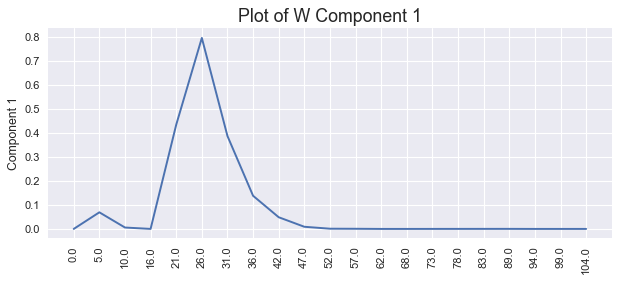

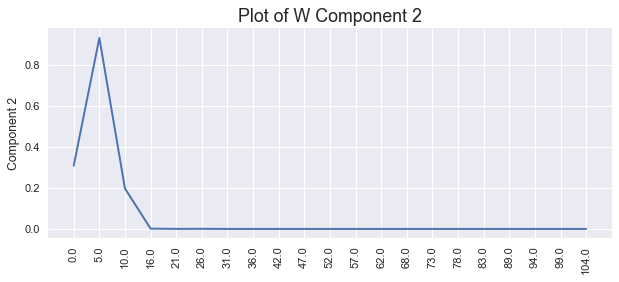

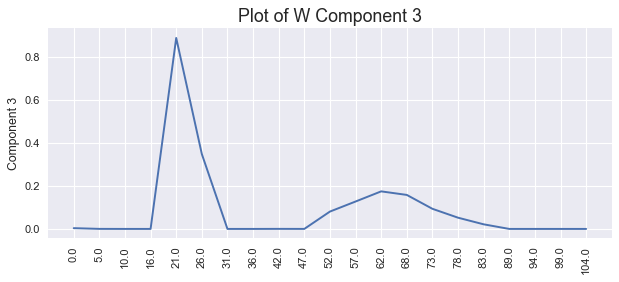

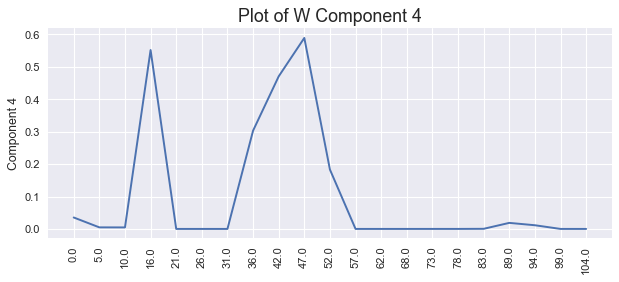

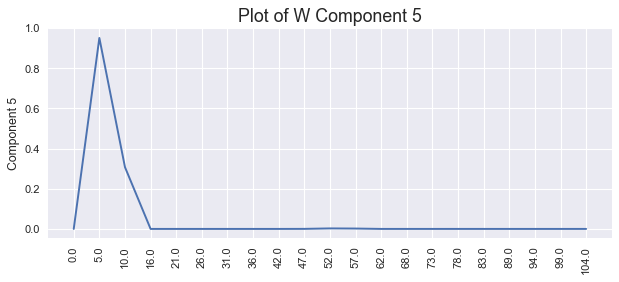

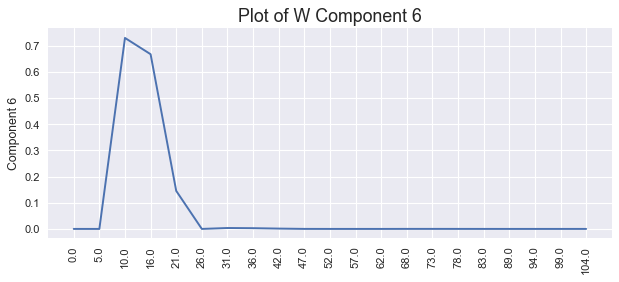

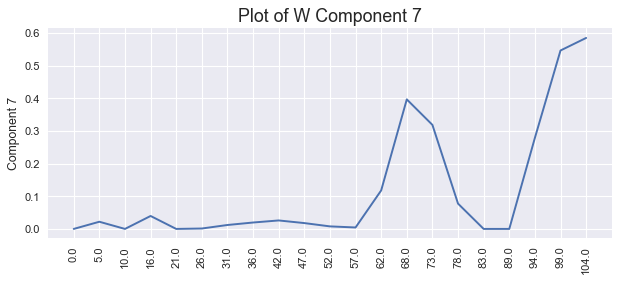

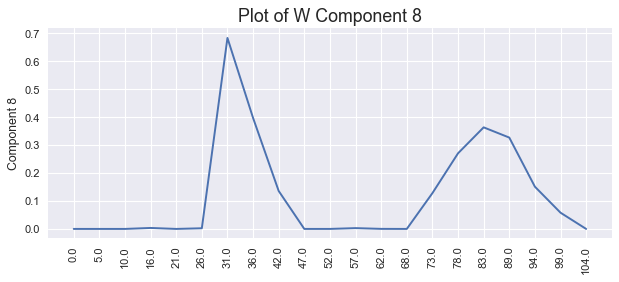

In [8]:
#freq_ticks = np.around(np.linspace(0, 100, num=len(filter_row_idx)), decimals=0)
freq_ticks = f[filter_row_idx]
#freq_ticks

# Normalize W_specnorm columns for plotting
W_plt = W_specnorm / np.linalg.norm(x=W_specnorm, ord=2, axis=0, keepdims=True)
plotW(W = W_plt, log=False, x_ticks_l=freq_ticks)
#plotH(H = H_specnorm, log=False, y_ticks_l=None)

## Spectrogram for a Single Trial

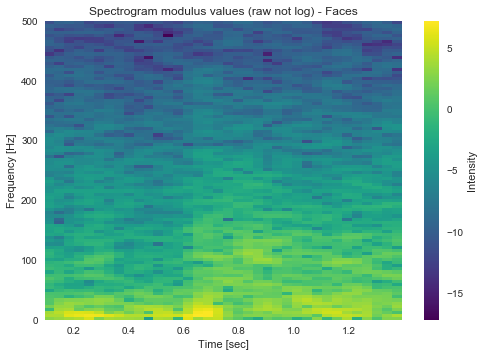

In [9]:
# Fit the spectrogram - no log
f, t, Sxx = erp_gen_spectrogram(x = all_pat_chn_trials[9][0], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx=log_Sxx)

# Plot the spectrogram
plt.pcolormesh(t, f, np.log(Sxx), cmap='viridis')
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

## Short Term Fourier Transform

In [10]:
f_stft, t_stft, Zxx_stft = signal.stft(x = all_pat_chn_trials[9][0], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)

#plt.pcolormesh(t_stft, f_stft, np.abs(Zxx_stft), vmin=0, vmax=5, cmap = 'viridis')
#plt.title('STFT Magnitude')
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.show()

In [11]:
#print(f"The spectrogram time granularity is \n{t} of \nlength {len(t)}")
#print(f"The stft granularity is \n{t_stft} of \nlength {len(t_stft)}")

In [12]:
print(f"spectrogram shape {Sxx[filter_row_idx, :].shape}")
print(f"STFT shape {Zxx_stft[filter_row_idx, :].shape}")
print(f"W shape {W_specnorm.shape}")

spectrogram shape (21, 37)
STFT shape (21, 43)
W shape (21, 8)


## Plot the $W$ Weighted STFTs

In [140]:
def wrapper_get_data(base_data_dir, 
                     patient_num, 
                     session_idx, 
                     tot_num_channels, 
                     core_cat, 
                     trials_type, 
                     trial_ord,
                     samp_trial_pop, 
                     noverlap,
                     time_samp_prop,
                     filter_row_idx,                                
                     log_Sxx,
                     specgram_ord,
                     fs, 
                     window, 
                     nperseg,
                     n_components,
                     init, 
                     random_state, 
                     beta_loss, 
                     solver,
                     max_iter):
    
    print(f"STARTING wrapper...")
    
    # Get all of the patient data
    print(f"Getting all_pat_chn_trials...")
    all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=trial_ord)
    
    print(f"The total number of trials is: {all_pat_chn_trials[0].shape[0]}")
    
    # NMF - produce the V, W, H specnorm matrices
    print(f"Getting V_specnorm, W_specnorm, H_specnorm...")
    V_specnorm, W_specnorm, H_specnorm = entire_specgram_nmf_wrapper_cust(all_patient_trials=all_pat_chn_trials,
                                           samp_trial_pop=samp_trial_pop, 
                                           noverlap=noverlap,
                                           time_samp_prop=time_samp_prop,
                                           filter_row_idx=filter_row_idx,                                
                                           log_Sxx=log_Sxx,
                                           specgram_ord=specgram_ord,
                                           fs=fs, 
                                           window=window, 
                                           nperseg=nperseg,
                                           n_components=n_components, 
                                           init=init, 
                                           random_state=random_state, 
                                           beta_loss=beta_loss, 
                                           solver=solver,
                                           max_iter=max_iter)
    
    # Normalize W_specnorm columns for plotting
    print(f"Getting W_plt...")
    W_plt = W_specnorm / np.linalg.norm(x=W_specnorm, ord=specgram_ord, axis=0, keepdims=True)
    
    
    # Fit a single spectrogram for the parameters
    # Fit the spectrogram - no log
    print(f"Getting f, t, Sxx...")
    f, t, Sxx = erp_gen_spectrogram(x = all_pat_chn_trials[0][0], fs=fs, 
                                    window=window, nperseg=nperseg, noverlap=noverlap, 
                                    log_Sxx=log_Sxx)
    freq_ticks = f[filter_row_idx]
    
    # Fit a single STFT to a sample trial to get the relevant parameters
    print(f"Getting f_stft, t_stft, Zxx_stft...")
    f_stft, t_stft, Zxx_stft = signal.stft(x = all_pat_chn_trials[0][0], fs=fs, window=window, 
                                           nperseg=nperseg, noverlap=noverlap)
    
    print(f"FINISHED wrapper...")
    
    out_dict = {'all_pat_chn_trials': all_pat_chn_trials,
                'patient_num': patient_num, 
                'session_idx': session_idx, 
                'core_cat': core_cat,
                'V_specnorm': V_specnorm, 
                'W_specnorm': W_specnorm, 
                'H_specnorm': H_specnorm,
                'W_plt': W_plt,
                'fs': fs,
                'window': window,
                'nperseg': nperseg,
                'noverlap': noverlap,
                'f': f, 
                't': t, 
                'Sxx': Sxx,
                'freq_ticks': freq_ticks,
                'f_stft': f_stft, 
                't_stft': t_stft, 
                'Zxx_stft': Zxx_stft}
    return out_dict

# Run Wrapper

## P41 and P35 data creation

In [141]:
# COMMON PARAMETERS for the DATA GENERATION

base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
trials_type = "category"
session_idx = 1
trial_ord = None

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 156
log_Sxx=False

samp_trial_pop = 0.8 # 100% sampling of trials
time_samp_prop = 1.0 # 100% sampling of time
specgram_ord = 2 # Normalize spectrogram using Frobenius Norm
filter_row_idx=range(21)
n_components = 8 
init = 'random' 
random_state = 0
beta_loss = 'itakura-saito' # IS Divergence
solver = 'mu'
max_iter = 400

# P41 Faces
P41_faces_data = wrapper_get_data(base_data_dir=base_data_dir, 
                                  patient_num=41, 
                                  session_idx=session_idx, 
                                  tot_num_channels=range(96), 
                                  core_cat="Faces", 
                                  trials_type=trials_type, 
                                  trial_ord=trial_ord,
                                  samp_trial_pop=samp_trial_pop, 
                                  noverlap=noverlap,
                                  time_samp_prop=time_samp_prop,
                                  filter_row_idx=filter_row_idx,                                
                                  log_Sxx=log_Sxx,
                                  specgram_ord=specgram_ord,
                                  fs=fs, 
                                  window=window, 
                                  nperseg=nperseg,
                                  n_components=n_components,
                                  init=init, 
                                  random_state=random_state, 
                                  beta_loss=beta_loss, 
                                  solver=solver,
                                  max_iter=max_iter)

STARTING wrapper...
Getting all_pat_chn_trials...
The total number of trials is: 84
Getting V_specnorm, W_specnorm, H_specnorm...
The number of trials sampled is: 67
comb_all_channels_specgrams: (21, 237984)
time_samp_idx length: 237984
comb_specgram_time_sample: (21, 237984)
we are using the 2-norm to normalize specgram
STARTING NMF...
V: (21, 237984)
W: (21, 8)
H: (8, 237984)
NMF COMPLETE!
Getting W_plt...
Getting f, t, Sxx...
Getting f_stft, t_stft, Zxx_stft...
FINISHED wrapper...


### Wrapper needs to do the following

1. Take W_src, faces, words, hammers, channel_num
2. Ensure channel_num is converted to channel_idx
3. Obtain all STFTs for for faces (initially) for the supplied face trials for the given channel

In [177]:
### Produce STFT calculations

def stft_filt_normalize(Zxx_stft, filter_row_idx, mat_ord):
    Zxx_stft_filt = np.abs(Zxx_stft[filter_row_idx, :])
    return Zxx_stft_filt / np.linalg.norm(x=Zxx_stft_filt, ord=mat_ord)

### Apply W Component to STFTs

def apply_W_comp_trial(Zxx_stft_filt_scl, W_mat, comp_idx):

    # Get the specified component
    W_comp = W_mat[:, comp_idx]

    # Normalize the W_component using 2-norm
    W_comp_scl = W_comp/np.linalg.norm(x=W_comp, ord=2, axis=0, keepdims=True)

    return Zxx_stft_filt_scl.T @ W_comp_scl

def get_all_stft(all_data_src, chnl_idx):
    
    # Extract all relevant parameters from the source
    all_pat_chn_trials = all_data_src['all_pat_chn_trials'][chnl_idx]
    num_trials = all_pat_chn_trials.shape[0]   
    fs = all_data_src['fs']
    window = all_data_src['window']
    nperseg = all_data_src['nperseg']
    noverlap = all_data_src['noverlap']    
    
    get_all_stft = [signal.stft(x = all_pat_chn_trials[tr_idx], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
                    for tr_idx in range(num_trials)]
    return get_all_stft

def get_trial_proj(W_mat, comp_idx, get_Zxx_stft_filt_scl):
    """Apply W projection for a collection of trial STFTs
       Return the mean of all trials so that we can plot it accordingly
    """
    
    # Calculate the projection for the specified W component
    out_proj = [apply_W_comp_trial(Zxx_stft_filt_scl=stft_scl, W_mat=W_mat, comp_idx=comp_idx)
                for stft_scl in get_Zxx_stft_filt_scl]
    out_proj_stack = np.vstack(out_proj)

    # Get the mean as a separate row
    mean_proj = np.mean(a=out_proj_stack, axis=0)
    
    return out_proj_stack, mean_proj

def wrapper_stft_W_proj(W_all_data_src,
                        all_faces_src,
                        all_words_src,
                        all_hammers_src,
                        chnl_num,
                        filter_row_idx,
                        mat_ord):
    
    # Get the channel index
    chnl_idx = chnl_num - 1
    
    # Get the W matrix
    W_specnorm = W_all_data_src['W_specnorm']
    
    # Get the Frobenius normalized W matrix
    # This will be used for plotting and also applying the scaling
    W_plt = W_all_data_src['W_plt']
    
    # Get the number of W components we will project onto
    n_components = W_plt.shape[1]
    
    # Get STFTs    
    get_all_stft_faces = get_all_stft(all_data_src=all_faces_src, chnl_idx=chnl_idx) # FACES - STFTs
    get_all_stft_words = get_all_stft(all_data_src=all_words_src, chnl_idx=chnl_idx) # WORDS - STFTs
    get_all_stft_hammers = get_all_stft(all_data_src=all_hammers_src, chnl_idx=chnl_idx) # HAMMERS - STFTs
    
    # Get filtered STFT, absolute valued, each entry normalized by frobenius norm of entire matrix
    get_Zxx_stft_filt_scl_faces = [stft_filt_normalize(Zxx_stft=stft[2], filter_row_idx=filter_row_idx, mat_ord=mat_ord) 
                                   for stft in get_all_stft_faces] 
    get_Zxx_stft_filt_scl_words = [stft_filt_normalize(Zxx_stft=stft[2], filter_row_idx=filter_row_idx, mat_ord=mat_ord) 
                                   for stft in get_all_stft_words] 
    get_Zxx_stft_filt_scl_hammers = [stft_filt_normalize(Zxx_stft=stft[2], filter_row_idx=filter_row_idx, mat_ord=mat_ord) 
                                   for stft in get_all_stft_hammers] 
    
    # This is used to plot the x components on W_plt
    x_ticks_l = W_all_data_src['f'][filter_row_idx]
    
    for comp_idx in range(n_components):
        
        # Set up the subplots
        fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k', squeeze=False)
        fig.subplots_adjust(hspace = 0.5, wspace=0.2)        
        axs = axs.flatten()
        
        fig.suptitle(f"W Component: {comp_idx + 1}", fontsize=14)
        
        # W Component
        axs[0].plot(W_plt[:, comp_idx])
        axs[0].set_ylim(0, W_plt.max())
        axs[0].set_title(f"W{comp_idx + 1}, P{W_all_data_src['patient_num']}, Session {W_all_data_src['session_idx']}, {W_all_data_src['core_cat']}", fontsize=14)
        axs[0].set_xticks(range(0, W_plt.shape[0]))
        axs[0].set_xticklabels(np.around(x_ticks_l), rotation='vertical')
        axs[0].set_xlabel('Frequency')
        
        # Faces
        out_convs_stack_faces, mean_convs_faces = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
                                                           get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_faces)
        t_stft = all_faces_src['t_stft']
        axs[1].plot(out_convs_stack_faces.T[:,:])
        axs[1].plot(mean_convs_faces, marker='', color='black', linewidth=8, alpha=1.5)
        axs[1].set_title(f"P{all_faces_src['patient_num']}, Session {all_faces_src['session_idx']}, {all_faces_src['core_cat']}, Channel {chnl_idx + 1}", fontsize=14)
        axs[1].set_xticks(range(len(t_stft)))
        axs[1].set_xticklabels(np.around(t_stft*1000, 0), rotation='vertical')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel(f"W-Scaled STFT")
        
        # Words
        out_convs_stack_words, mean_convs_words = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
                                                           get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_faces)
        t_stft = all_words_src['t_stft']
        axs[2].plot(out_convs_stack_words.T[:,:])
        axs[2].plot(mean_convs_words, marker='', color='black', linewidth=8, alpha=1.5)
        axs[2].set_title(f"P{all_words_src['patient_num']}, Session {all_words_src['session_idx']}, {all_words_src['core_cat']}, Channel {chnl_idx + 1}", fontsize=14)
        axs[2].set_xticks(range(len(t_stft)))
        axs[2].set_xticklabels(np.around(t_stft*1000, 0), rotation='vertical')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel(f"W-Scaled STFT")
        
        # Hammers
        out_convs_stack_hammers, mean_convs_hammers = get_trial_proj(W_mat=W_specnorm, comp_idx=comp_idx, 
                                                           get_Zxx_stft_filt_scl=get_Zxx_stft_filt_scl_hammers)
        t_stft = all_hammers_src['t_stft']
        axs[3].plot(out_convs_stack_hammers.T[:,:])
        axs[3].plot(mean_convs_hammers, marker='', color='black', linewidth=8, alpha=1.5)
        axs[3].set_title(f"P{all_hammers_src['patient_num']}, Session {all_hammers_src['session_idx']}, {all_hammers_src['core_cat']}, Channel {chnl_idx + 1}", fontsize=14)
        axs[3].set_xticks(range(len(t_stft)))
        axs[3].set_xticklabels(np.around(t_stft*1000, 0), rotation='vertical')
        axs[3].set_xlabel('Time')
        axs[3].set_ylabel(f"W-Scaled STFT")

# P41 - Session 1, Faces - Channel 10 (Face sensitive channel)

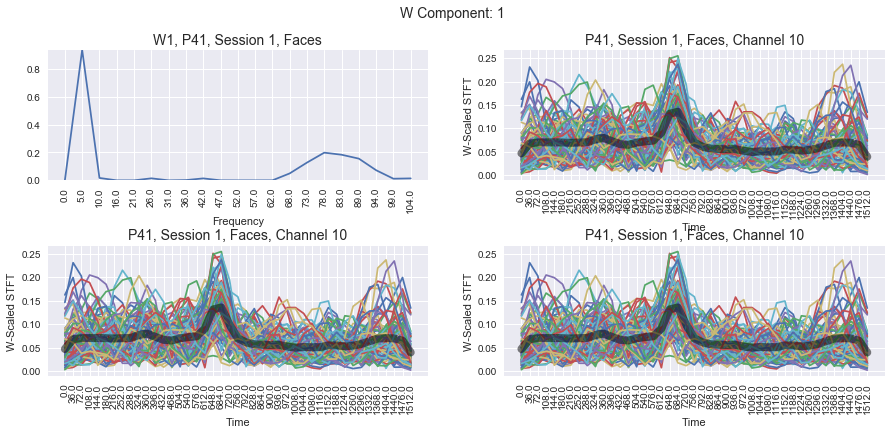

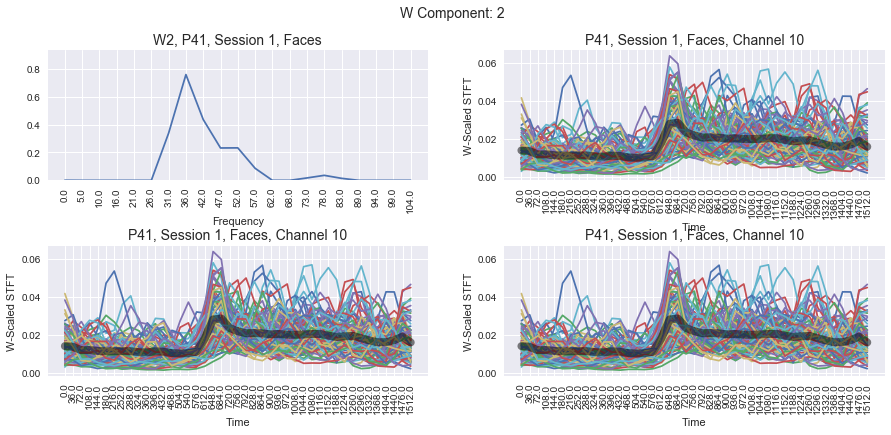

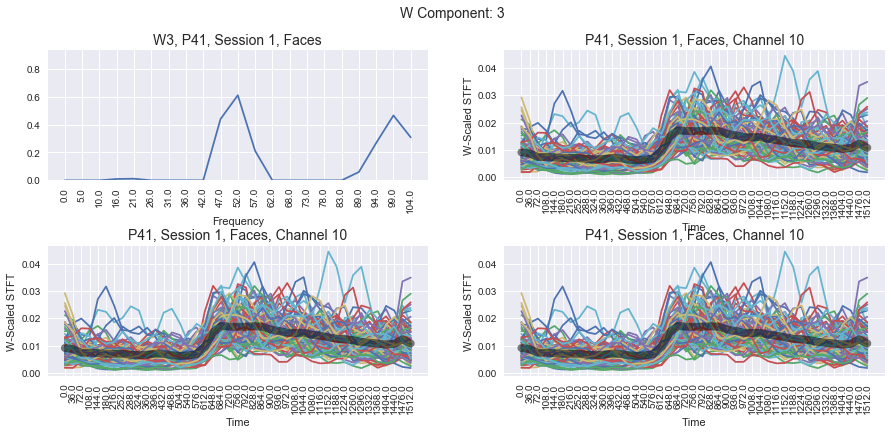

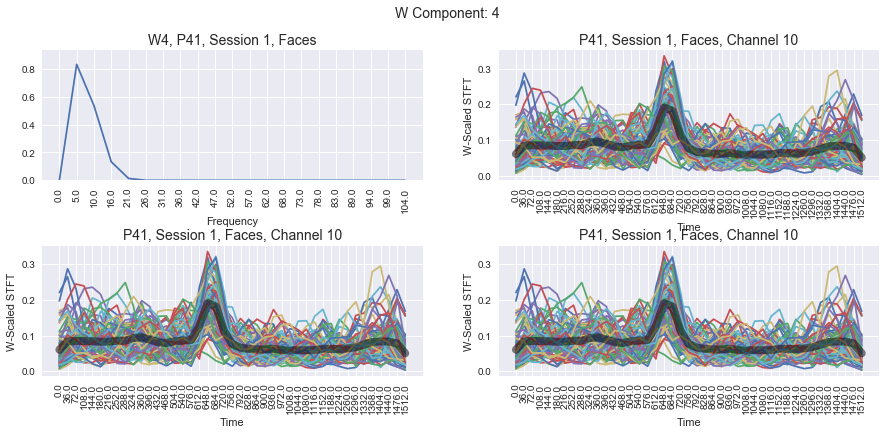

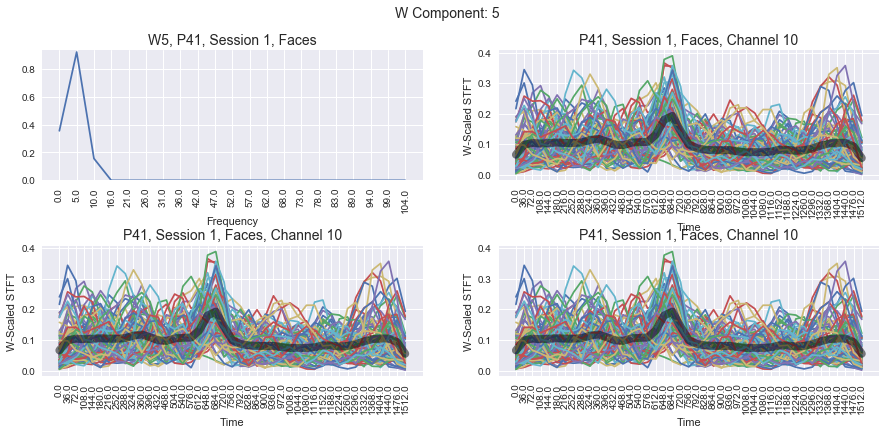

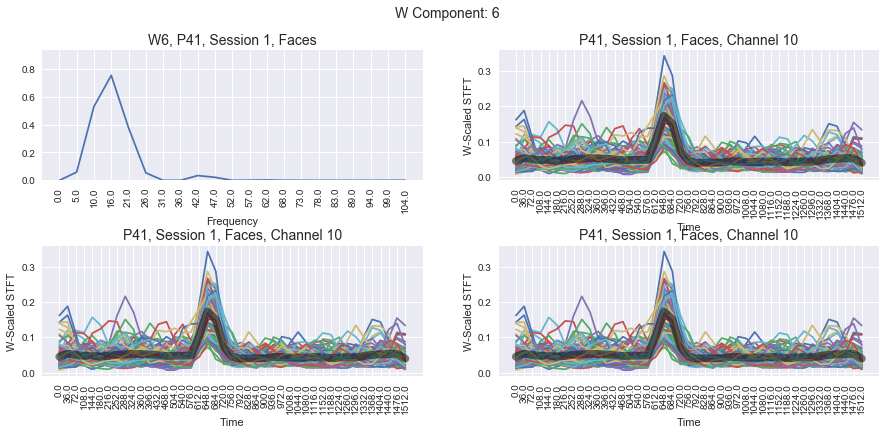

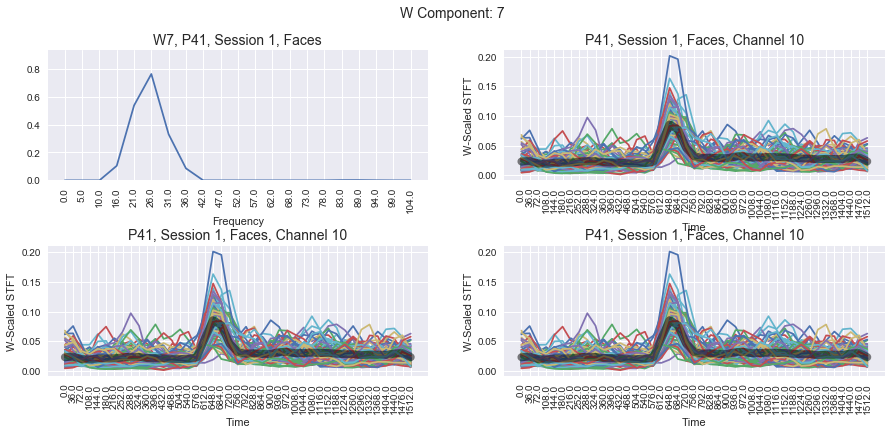

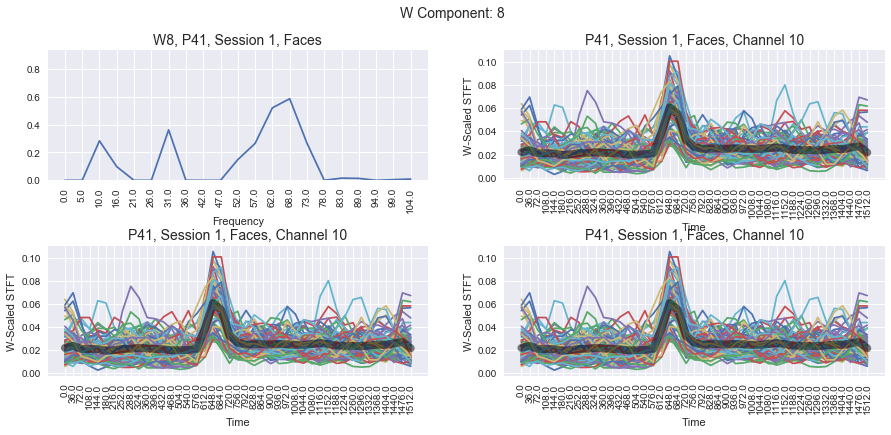

In [178]:
chnl_num=10
wrapper_stft_W_proj(W_all_data_src=P41_faces_data,
                    all_faces_src=P41_faces_data,
                    all_words_src=P41_faces_data,
                    all_hammers_src=P41_faces_data,
                    chnl_num=chnl_num,
                    filter_row_idx=range(21),
                    mat_ord='fro')